# PAI CA2: Phase 2 Taxi Safety Classifier | Just Taxi
## Names & Admin No:
### Quah Johnnie (2007476), Jayden Yap (2112790), Bey Wee Loon (2112802)


<br><br>

<h3 align="center"><a id="content-table"></a>Notebook Table of Contents (Clickable)</h3>

| Description  | Headings | 
| --- | --- |
| <p style="color:blue;font-weight:bold;font-size:larger">Extracting data</p>| <p style="font-size:larger">[`1`](#1) |
| <p style="color:blue;font-weight:bold;font-size:larger">Handling Missing Values</p>| <p style="font-size:larger">[`2`](#2) |
| <p style="color:blue;font-weight:bold;font-size:larger">Outlier Analysis</p> | <p style="font-size:larger">[`3`](#3) |
| <p style="color:blue;font-weight:bold;font-size:larger">Feature Engineering</p> | <p style="font-size:larger">[`4`](#4) |
| <p style="color:blue;font-weight:bold;font-size:larger">Addressing Highly Correlated Columns</p> | <p style="font-size:larger">[`5`](#5) |
| <p style="color:blue;font-weight:bold;font-size:larger">Feature Selection</p>| <p style="font-size:larger">[`6`](#6) |
| <p style="color:blue;font-weight:bold;font-size:larger">Outlier Removal Techniques Comparison</p> | <p style="font-size:larger">[`7`](#7) |
| <p style="color:blue;font-weight:bold;font-size:larger">Handling Imbalanced Classes</p>| <p style="font-size:larger">[`8`](#8) |
| <p style="color:blue;font-weight:bold;font-size:larger">Model Comparison</p> | <p style="font-size:larger">[`9`](#9) |
| <p style="color:blue;font-weight:bold;font-size:larger">Hyperparameter Tuning</p>| <p style="font-size:larger">[`10`](#10) |
| <p style="color:blue;font-weight:bold;font-size:larger">Training an unsupervised model</p> | <p style="font-size:larger">[`11`](#11) |

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import dask.dataframe as dd
import numpy as np
import re, mlflow

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D

import dask_ml.linear_model

from sklearn.ensemble import IsolationForest

from dask.diagnostics import ProgressBar
from sklearn.ensemble import IsolationForest

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier

# 1. Extracting data <a id="1"></a>

<br>

- [Back to content table](#content-table)

### Connect to MSSQL server

In [2]:
# Connect to MSSQL server
server = 'JONI\SQLEXPRESS' # <- change server
database = 'Taxi_Trip'
engine = create_engine(f'mssql+pyodbc://{server}/{database}?driver=SQL Server')

### 1.1 Driver Data Table

In [3]:
%%time
# Retrieve Data
connection = engine.connect()
cursor = connection.execute('SELECT * FROM dataLake.drivers')
drivers_df = dd.from_pandas(pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys()), npartitions=4).compute()

display(drivers_df.head())
print(f'Shape: {drivers_df.shape}')

<timed exec>:3: RemovedIn20Warning: Deprecated API features detected! These feature(s) are not compatible with SQLAlchemy 2.0. To prevent incompatible upgrades prior to updating applications, ensure requirements files are pinned to "sqlalchemy<2.0". Set environment variable SQLALCHEMY_WARN_20=1 to show all deprecation warnings.  Set environment variable SQLALCHEMY_SILENCE_UBER_WARNING=1 to silence this message. (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)


,driver_id,name,date_of_birth,gender,car_model,car_make_year,rating
0,1,Tressa,1/12/1992,Female,Mazda,2011,4.5
1,2,Virgilio,10/23/1992,Male,Mazda,2004,3.5
2,3,Bert,8/10/1989,Male,Nissan,2008,4.5
3,4,Mahmoud,8/14/1981,Male,Toyota,2008,4.5
4,5,Felecia,7/20/1990,Female,Hyundai,2010,4.5


Shape: (148, 7)
CPU times: total: 0 ns
Wall time: 141 ms


### 1.2 Safety Labels Table

In [4]:
%%time
# Retrieve Data
cursor = connection.execute('SELECT * FROM dataLake.safety_labels')
safety_labels_df = dd.from_pandas(pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys()), npartitions=4).compute()

display(safety_labels_df.head(5))
print(f'Shape: {safety_labels_df.shape}')

,booking_id,driver_id,label
0,0,48,0
1,1,74,1
2,2,40,1
3,4,112,1
4,6,68,0


Shape: (20000, 3)
CPU times: total: 46.9 ms
Wall time: 63.5 ms


### 1.3 Sensor Table

In [5]:
%%time
# Retrieve Data
cursor = connection.execute('SELECT * FROM dataLake.sensor')
sensor_df = dd.from_pandas(pd.DataFrame(data=cursor.fetchall(), columns=cursor.keys()), npartitions=4).compute()
connection.close()

display(sensor_df.head(5))
print(f'Shape: {sensor_df.shape}')
#7+ million rows

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
0,1202590843006,3.000,353.0,1.228867,8.900100,3.986968,0.008221,0.002269,-0.009966,1362.0,0.000000,1
1,274877907034,9.293,17.0,0.032775,8.659933,4.737300,0.024629,0.004028,-0.010858,257.0,0.190000,2
2,884763263056,3.000,189.0,1.139675,9.545974,1.951334,-0.006899,-0.015080,0.001122,973.0,0.667059,3
3,1073741824054,3.900,126.0,3.871542,10.386364,-0.136474,0.001344,-0.339601,-0.017956,902.0,7.913285,4
4,1056561954943,3.900,50.0,-0.112882,10.550960,-1.560110,0.130568,-0.061697,0.161530,820.0,20.419409,5


Shape: (7469656, 12)
CPU times: total: 29.9 s
Wall time: 44.7 s


## Change Datatypes (Save RAM)

Drivers dataframe only takes up 8.2 KB | That is alright

In [6]:
drivers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   driver_id      148 non-null    int64 
 1   name           148 non-null    object
 2   date_of_birth  148 non-null    object
 3   gender         148 non-null    object
 4   car_model      148 non-null    object
 5   car_make_year  148 non-null    object
 6   rating         148 non-null    object
dtypes: int64(1), object(6)
memory usage: 8.2+ KB


Hmm safety labels dataframes take up more memory, but if we turn it to a 32-bit integer we are losing a lot of values

In [7]:
safety_labels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   booking_id  20000 non-null  int64
 1   driver_id   20000 non-null  int64
 2   label       20000 non-null  int64
dtypes: int64(3)
memory usage: 468.9 KB


In [8]:
safety_labels_df.astype('int64').max()

booking_id    1709396983975
driver_id               148
label                     1
dtype: int64

In [9]:
safety_labels_df.astype('int32').max()

booking_id    204
driver_id     148
label           1
dtype: int32

In [10]:
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   accuracy        float64
 2   bearing         float64
 3   acceleration_x  float64
 4   acceleration_y  float64
 5   acceleration_z  float64
 6   gyro_x          float64
 7   gyro_y          float64
 8   gyro_z          float64
 9   second          float64
 10  speed           float64
 11  sensorKey       int64  
dtypes: float64(10), int64(2)
memory usage: 683.9 MB


In [11]:
sensor_df.describe()

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
count,7.469656e+06,7.351631e+06,7.350253e+06,7.364539e+06,7.346553e+06,7.370520e+06,7.336398e+06,7.329944e+06,7.404168e+06,7.469656e+06,7.346079e+06,7.469656e+06
mean,8.183371e+11,1.162066e+01,1.689699e+02,6.918624e-02,4.467981e+00,8.964518e-01,-1.738806e-03,2.046962e-04,-2.468964e-04,3.669335e+03,9.003918e+00,3.734828e+06
std,4.953348e+11,8.727007e+01,1.072942e+02,1.424023e+00,8.130443e+00,3.252218e+00,1.445958e-01,3.371285e-01,1.480074e-01,1.378355e+06,8.105558e+00,2.156304e+06
min,0.000000e+00,7.500000e-01,0.000000e+00,-3.898399e+01,-5.780019e+01,-7.844842e+01,-4.845575e+01,-5.734489e+01,-5.355445e+01,0.000000e+00,-2.000000e+00,1.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.087219e-01,-2.026514e+00,-9.295166e-01,-2.679080e-02,-2.996360e-02,-1.872362e-02,2.410000e+02,1.017968e+00,1.867415e+06
50%,8.074539e+11,4.247000e+00,1.688404e+02,6.130981e-02,9.081485e+00,7.776642e-01,-6.561279e-04,2.583960e-04,-3.051758e-05,5.200000e+02,7.524900e+00,3.734828e+06
75%,1.254130e+12,8.000000e+00,2.630000e+02,6.355286e-01,9.710308e+00,2.753036e+00,2.329046e-02,3.142024e-02,1.825411e-02,8.620000e+02,1.547718e+01,5.602242e+06
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.281000e+01,7.805576e+01,3.870809e+01,8.031496e+01,4.505986e+01,6.193165e+08,8.803725e+01,7.469656e+06


Since we know that booking_id needs to be int64, we will only change the datatype of all the floats to 32 bit

In [12]:
for col in sensor_df.columns:
    if sensor_df[col].dtype == 'float64':
        sensor_df[col] = sensor_df[col].astype('float32')
sensor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7469656 entries, 0 to 7469655
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   booking_id      int64  
 1   accuracy        float32
 2   bearing         float32
 3   acceleration_x  float32
 4   acceleration_y  float32
 5   acceleration_z  float32
 6   gyro_x          float32
 7   gyro_y          float32
 8   gyro_z          float32
 9   second          float32
 10  speed           float32
 11  sensorKey       int64  
dtypes: float32(10), int64(2)
memory usage: 398.9 MB


In [13]:
sensor_df.describe()

,booking_id,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,sensorKey
count,7.469656e+06,7.351631e+06,7.350253e+06,7.364539e+06,7.346553e+06,7.370520e+06,7.336398e+06,7.329944e+06,7.404168e+06,7.469656e+06,7.346079e+06,7.469656e+06
mean,8.183371e+11,1.162065e+01,1.689698e+02,6.918617e-02,4.467984e+00,8.964521e-01,-1.738805e-03,2.046962e-04,-2.468965e-04,3.669337e+03,9.003914e+00,3.734828e+06
std,4.953348e+11,8.727007e+01,1.072942e+02,1.424023e+00,8.130443e+00,3.252218e+00,1.445958e-01,3.371285e-01,1.480074e-01,1.378356e+06,8.105558e+00,2.156304e+06
min,0.000000e+00,7.500000e-01,0.000000e+00,-3.898399e+01,-5.780019e+01,-7.844842e+01,-4.845575e+01,-5.734489e+01,-5.355445e+01,0.000000e+00,-2.000000e+00,1.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.087219e-01,-2.026514e+00,-9.295166e-01,-2.679080e-02,-2.996360e-02,-1.872362e-02,2.410000e+02,1.017968e+00,1.867415e+06
50%,8.074539e+11,4.247000e+00,1.688404e+02,6.130981e-02,9.081485e+00,7.776642e-01,-6.561279e-04,2.583960e-04,-3.051758e-05,5.200000e+02,7.524900e+00,3.734828e+06
75%,1.254130e+12,8.000000e+00,2.630000e+02,6.355286e-01,9.710308e+00,2.753036e+00,2.329046e-02,3.142024e-02,1.825411e-02,8.620000e+02,1.547718e+01,5.602242e+06
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.281000e+01,7.805576e+01,3.870809e+01,8.031496e+01,4.505986e+01,6.193165e+08,8.803725e+01,7.469656e+06


min, max & mean did not change much after we change datatypes from float64 to float32. Seems like float32 can be use!<br>
we managed cut down the memory size by half

# 2. Handling Missing Values <a id="2"></a>

<br>

- [Back to content table](#content-table)

In [14]:
display(sensor_df.isna().sum())

booking_id             0
accuracy          118025
bearing           119403
acceleration_x    105117
acceleration_y    123103
acceleration_z     99136
gyro_x            133258
gyro_y            139712
gyro_z             65488
second                 0
speed             123577
sensorKey              0
dtype: int64

### 2.1 Drop sensorKey & NaN in Accuracy
- It does not make sense to impute accuracy

In [15]:
sensor_df.dropna(subset=['accuracy'], inplace=True)
sensor_df.drop(columns=['sensorKey'], inplace=True)

In [16]:
display(sensor_df['accuracy'].isna().sum())

0

### Impute Null Values

In [17]:
# Impute null values
sensor_df.reset_index(drop=True, inplace=True)

# Iterative imputer used to impute null values (With Dask linear model)
imp_mean = IterativeImputer(
   estimator=dask_ml.linear_model.LinearRegression(n_jobs=6),
   random_state=1
)

# Passing all columns except 'booking_id'
sensor_df_cols = list(sensor_df.columns[1:])
num_df = sensor_df[sensor_df_cols]

# Imputing null values
sensor_list = imp_mean.fit_transform(num_df)
newSensor_df = pd.DataFrame(sensor_list, columns=sensor_df_cols)
newSensor_df['booking_id'] = sensor_df['booking_id'].copy()

display(newSensor_df.isna().sum())
del sensor_df

accuracy          0
bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
speed             0
booking_id        0
dtype: int64

### Correlation Plot 
- Check if any columns are highly correlated...seems fine

In [18]:
def plotCorrelation(data, title, annot=True):
    # Compute the correlation matrix
    corr = data.corr()
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
                annot_kws={"size": 10},fmt=".2f", square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
    plt.title(title)
    plt.show()

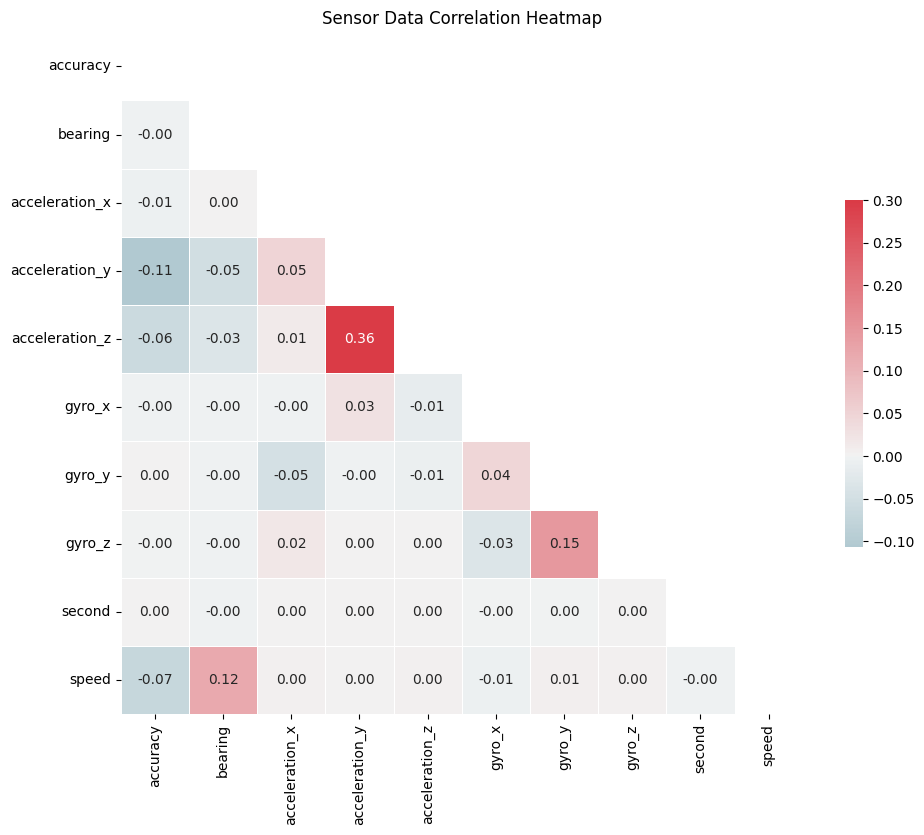

In [19]:
plotCorrelation(newSensor_df.drop(['booking_id'], axis=1), 'Sensor Data Correlation Heatmap')

# 3. Outlier Analysis <a id="3"></a>
### Univariate Outlier Detection:
- Domain knownledge applied to remove outliers the 7.4 million data
- Using multivariant outlier to remove outliers from the 7.4 million records would take hours
- Later multivariable outlier detection will be used (After aggregation)

### Multivariate Outlier Detection:
- Isolation Forest will be used for multivariate outlier detection

<br>

- [Back to content table](#content-table)

### Univariate Outlier Detection

In [20]:
# Save a copy of original dataframe
import copy
og_sensor = copy.deepcopy(newSensor_df)

In [21]:
def returnOutliers(df,columnName,magnitude=1.5):
    IQR = df[columnName].quantile(0.75) - df[columnName].quantile(0.25)
    lowerFence = df[columnName].quantile(0.25) - (IQR * magnitude)
    upperFence = df[columnName].quantile(0.75) + (IQR * magnitude)
    outlier_df = df[columnName][(df[columnName]<=lowerFence) | (df[columnName]>=upperFence)]
    print('Number of outliers Dropped: ',len(outlier_df))
    return outlier_df

def returnUpper(df,columnName,magnitude=3):
    IQR = df[columnName].quantile(0.75) - df[columnName].quantile(0.25)
    upperFence = df[columnName].quantile(0.75) + (IQR * magnitude)
    outlier_df = df[columnName][(df[columnName]>=upperFence)]
    print('Number of outliers Dropped: ',len(outlier_df))
    return outlier_df

In [22]:
display(newSensor_df.min())
display(newSensor_df.max())

accuracy           0.750000
bearing           -1.296322
acceleration_x   -38.983994
acceleration_y   -57.800190
acceleration_z   -78.448418
gyro_x           -48.455750
gyro_y           -57.344891
gyro_z           -37.465385
second             0.000000
speed            -29.132727
booking_id         0.000000
dtype: float64

accuracy          6.070101e+03
bearing           3.599995e+02
acceleration_x    6.687346e+01
acceleration_y    7.281000e+01
acceleration_z    7.805576e+01
gyro_x            3.870809e+01
gyro_y            8.031496e+01
gyro_z            4.505986e+01
second            6.193165e+08
speed             8.803725e+01
booking_id        1.709397e+12
dtype: float64

Bearing and Speed minimum should be 0 and max is 360 (domain knownledge better)

In [23]:
newSensor_df['bearing'] = newSensor_df['bearing'].clip(lower=0)
newSensor_df['speed'] = newSensor_df['speed'].clip(lower=0)

Using the IQR fence, we will drop the outliers where it is 7 IQR from lower/upper quartile (Standard is 1.5 or 1.7)

In [24]:
def outlierAnalysis(df=newSensor_df, column=None, magnitude=1.5, upperOnly = False):
    if not upperOnly:
        outliers = returnOutliers(df,column, magnitude)
    else:
        outliers = returnUpper(df,column, magnitude)
    print(f'Outlier Minimum For {column}: {outliers.min()}')
    print(f'Outlier Maximum For {column}: {outliers.max()}')
    print(f'Outlier Mean {outliers.mean()}')
    
    return outliers.index

Using magnitude 7 IQR for upper and lower fence for gyro

In [25]:
newSensor_df.drop(outlierAnalysis(newSensor_df,'gyro_x',magnitude=12), inplace=True)
newSensor_df.drop(outlierAnalysis(newSensor_df,'gyro_y',magnitude=12), inplace=True)
newSensor_df.drop(outlierAnalysis(newSensor_df,'gyro_z',magnitude=12), inplace=True)

Number of outliers Dropped:  45194
Outlier Minimum For gyro_x: -48.45574951171875
Outlier Maximum For gyro_x: 38.70808792114258
Outlier Mean -0.005732840392738581
Number of outliers Dropped:  37997
Outlier Minimum For gyro_y: -27.12116813659668
Outlier Maximum For gyro_y: 52.2602424621582
Outlier Mean -0.0768883153796196
Number of outliers Dropped:  25995
Outlier Minimum For gyro_z: -12.614401817321777
Outlier Maximum For gyro_z: 9.951005935668945
Outlier Mean -0.002035723999142647


Using magnitude 3.4 IQR for upper and lower fence for acceleration

In [26]:
newSensor_df.drop(outlierAnalysis(newSensor_df,'acceleration_x',magnitude=12), inplace=True)
newSensor_df.drop(outlierAnalysis(newSensor_df,'acceleration_y',magnitude=12), inplace=True)
newSensor_df.drop(outlierAnalysis(newSensor_df,'acceleration_z',magnitude=12), inplace=True)

Number of outliers Dropped:  152
Outlier Minimum For acceleration_x: -33.44083786010742
Outlier Maximum For acceleration_x: 29.616470336914062
Outlier Mean -1.6980048418045044
Number of outliers Dropped:  0
Outlier Minimum For acceleration_y: nan
Outlier Maximum For acceleration_y: nan
Outlier Mean nan
Number of outliers Dropped:  12
Outlier Minimum For acceleration_z: -58.72074508666992
Outlier Maximum For acceleration_z: 78.05575561523438
Outlier Mean 21.18684959411621


Speed where car is moving faster than 36.89m/s is dropped (36.89m/s is about 130+ km/h)

In [27]:
newSensor_df.drop(outlierAnalysis(newSensor_df,'speed',magnitude=1.5,upperOnly = True), inplace=True)

Number of outliers Dropped:  85
Outlier Minimum For speed: 36.739803314208984
Outlier Maximum For speed: 88.0372543334961
Outlier Mean 39.30602264404297


In [28]:
newSensor_df.drop(outlierAnalysis(newSensor_df,'second',magnitude=12,upperOnly = True), inplace=True)

Number of outliers Dropped:  34
Outlier Minimum For second: 619315328.0
Outlier Maximum For second: 619316544.0
Outlier Mean 619315712.0


Lets see min, max and mean of original vs univariate outlier removed
- Seems like extreme values are removed, min and max seems more 'normal'

In [29]:
# Original dataset, with outliers
og_sensor.describe()

,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,booking_id
count,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06
mean,1.162066e+01,1.689563e+02,6.918514e-02,4.467709e+00,8.962134e-01,-1.733407e-03,1.789847e-04,-2.510934e-04,3.550076e+03,9.002687e+00,8.183458e+11
std,8.727007e+01,1.064551e+02,1.413816e+00,8.071938e+00,3.233408e+00,1.431632e-01,3.339006e-01,1.458490e-01,1.351304e+06,8.039881e+00,4.953331e+11
min,7.500000e-01,-1.296322e+00,-3.898399e+01,-5.780019e+01,-7.844842e+01,-4.845575e+01,-5.734489e+01,-3.746539e+01,0.000000e+00,-2.913273e+01,0.000000e+00
25%,3.900000e+00,7.900000e+01,-4.980091e-01,-9.648633e-01,-9.241901e-01,-2.590942e-02,-2.929160e-02,-1.841816e-02,2.410000e+02,1.110000e+00,3.779571e+11
50%,4.247000e+00,1.680000e+02,6.700134e-02,9.052753e+00,7.972935e-01,-6.750061e-04,2.425135e-04,-3.490658e-05,5.200000e+02,7.720000e+00,8.074539e+11
75%,8.000000e+00,2.610000e+02,6.249057e-01,9.703699e+00,2.719000e+00,2.247862e-02,3.066524e-02,1.802063e-02,8.620000e+02,1.533112e+01,1.254130e+12
max,6.070101e+03,3.599995e+02,6.687346e+01,7.281000e+01,7.805576e+01,3.870809e+01,8.031496e+01,4.505986e+01,6.193165e+08,8.803725e+01,1.709397e+12


In [30]:
# Inliers from univariate outlier detection
newSensor_df.describe()

,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,booking_id
count,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06,7.242162e+06
mean,1.146137e+01,1.689952e+02,6.934907e-02,4.462358e+00,8.876828e-01,-1.634468e-03,2.974791e-05,-4.095973e-04,6.010095e+02,9.044140e+00,8.180595e+11
std,8.638815e+01,1.064558e+02,1.352000e+00,8.064168e+00,3.158647e+00,8.627993e-02,1.088907e-01,6.070606e-02,4.606105e+02,8.027208e+00,4.953589e+11
min,7.500000e-01,0.000000e+00,-1.384849e+01,-4.527352e+01,-4.237196e+01,-6.065414e-01,-7.400274e-01,-4.475901e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.900000e+00,7.900000e+01,-4.932206e-01,-9.976921e-01,-9.194015e-01,-2.535060e-02,-2.842552e-02,-1.806641e-02,2.420000e+02,1.128062e+00,3.779571e+11
50%,4.206000e+00,1.680663e+02,6.700000e-02,9.062330e+00,7.925050e-01,-6.682866e-04,2.441406e-04,-3.665191e-05,5.190000e+02,7.765673e+00,8.074539e+11
75%,8.000000e+00,2.610000e+02,6.200982e-01,9.704897e+00,2.698348e+00,2.197907e-02,2.983588e-02,1.753183e-02,8.610000e+02,1.537000e+01,1.254130e+12
max,6.070101e+03,3.599995e+02,1.392750e+01,4.909026e+01,4.581544e+01,6.031227e-01,7.414414e-01,4.470843e-01,8.234000e+03,3.671104e+01,1.709397e+12


In [31]:
# Inliers from univariate outlier detection
univariate_outlier_sensor = newSensor_df
del newSensor_df

### Multivariate Outlier Detection

In [32]:
multivariate_outlier_sensor = copy.deepcopy(og_sensor)

# Scale the data (z-scaling)
scaler = StandardScaler()
multivariate_outlier_sensor_scaled = scaler.fit_transform(multivariate_outlier_sensor)

# Outlier detection using Isolation Forest
lof = IsolationForest(contamination=0.02)
multivariate_outlier_sensor["anomaly"] = lof.fit_predict(multivariate_outlier_sensor_scaled)

# Mask to remove the outliers from imputed sensor data
mask = (multivariate_outlier_sensor["anomaly"] != -1)

In [33]:
# Inliers from multivariate outlier detection (Isolation Forest)
multivariate_outlier_sensor = multivariate_outlier_sensor[mask]

We still need to apply some domain knownledge (Speed & Bearing cannot be negative!)

In [34]:
# Clip values that are negative
multivariate_outlier_sensor['bearing'] = multivariate_outlier_sensor['bearing'].clip(lower=0)
multivariate_outlier_sensor['speed'] = multivariate_outlier_sensor['speed'].clip(lower=0)

Lets see min, max and mean of original vs multivariate outlier removed

In [35]:
# Original data with outliers
og_sensor.describe()

,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,booking_id
count,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06,7.351631e+06
mean,1.162066e+01,1.689563e+02,6.918514e-02,4.467709e+00,8.962134e-01,-1.733407e-03,1.789847e-04,-2.510934e-04,3.550076e+03,9.002687e+00,8.183458e+11
std,8.727007e+01,1.064551e+02,1.413816e+00,8.071938e+00,3.233408e+00,1.431632e-01,3.339006e-01,1.458490e-01,1.351304e+06,8.039881e+00,4.953331e+11
min,7.500000e-01,-1.296322e+00,-3.898399e+01,-5.780019e+01,-7.844842e+01,-4.845575e+01,-5.734489e+01,-3.746539e+01,0.000000e+00,-2.913273e+01,0.000000e+00
25%,3.900000e+00,7.900000e+01,-4.980091e-01,-9.648633e-01,-9.241901e-01,-2.590942e-02,-2.929160e-02,-1.841816e-02,2.410000e+02,1.110000e+00,3.779571e+11
50%,4.247000e+00,1.680000e+02,6.700134e-02,9.052753e+00,7.972935e-01,-6.750061e-04,2.425135e-04,-3.490658e-05,5.200000e+02,7.720000e+00,8.074539e+11
75%,8.000000e+00,2.610000e+02,6.249057e-01,9.703699e+00,2.719000e+00,2.247862e-02,3.066524e-02,1.802063e-02,8.620000e+02,1.533112e+01,1.254130e+12
max,6.070101e+03,3.599995e+02,6.687346e+01,7.281000e+01,7.805576e+01,3.870809e+01,8.031496e+01,4.505986e+01,6.193165e+08,8.803725e+01,1.709397e+12


In [36]:
# Inliers from Isolation Forest
multivariate_outlier_sensor.describe()

,accuracy,bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,speed,booking_id,anomaly
count,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7.204598e+06,7204598.0
mean,7.007557e+00,1.688113e+02,6.929965e-02,4.559142e+00,9.166975e-01,-1.527217e-03,-1.904832e-03,-1.212965e-03,3.176144e+03,9.082144e+00,8.185498e+11,1.0
std,1.239206e+01,1.062568e+02,1.321203e+00,8.007158e+00,3.091368e+00,9.272528e-02,1.888691e-01,6.975791e-02,1.263766e+06,8.006668e+00,4.945043e+11,0.0
min,7.500000e-01,0.000000e+00,-2.950944e+01,-2.963447e+01,-3.751308e+01,-5.217611e+00,-2.471980e+01,-1.903991e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.0
25%,3.900000e+00,7.900000e+01,-4.903290e-01,-1.148529e-01,-8.882760e-01,-2.525491e-02,-2.851868e-02,-1.810950e-02,2.410000e+02,1.220000e+00,3.865471e+11,1.0
50%,4.051000e+00,1.680000e+02,6.703765e-02,9.079090e+00,8.086416e-01,-6.664540e-04,1.983643e-04,-6.475172e-05,5.170000e+02,7.840000e+00,8.074539e+11,1.0
75%,8.000000e+00,2.610000e+02,6.165375e-01,9.708784e+00,2.705451e+00,2.186348e-02,2.959454e-02,1.731055e-02,8.570000e+02,1.539661e+01,1.245541e+12,1.0
max,1.899999e+03,3.599995e+02,2.282223e+01,4.756673e+01,7.805576e+01,9.181152e+00,5.226024e+01,4.622006e+00,6.193165e+08,8.803725e+01,1.709397e+12,1.0


# 4. Feature Engineering<a id="4"></a>

<br>

- [Back to content table](#content-table)

- lambda x: x.quantile(n) -> Interquartile percentile
- kurt -> Kurt, or Kurtosis, is a measure of the tailedness of a distribution
- skew -> Skew, or Skewness, is a measure of the asymmetry of a distribution

<br>

Note:
- Maybe can include lambda x: x.quantile(.75) - lambda x: x.quantile(.25) as IQR but idk
- I think lambda x: x.quantile(.5) and mean got a lot of correlation ah so maybe can drop 1 of them but...
- Take like 3 mins to run and will return all the aggregated columns + merge the other tables (driver + safety label)

In [37]:
multivariate_outlier_sensor.drop(['anomaly'], axis=1, inplace=True)

In [38]:
# Reset index
univariate_outlier_sensor.reset_index(drop=True, inplace=True)
multivariate_outlier_sensor.reset_index(drop=True, inplace=True)

In [39]:
def feature_engineer(sensor_data):
    # Aggregate mean, min, max, std, kurt, skew, 5th quantile, 25th quantile and 75th quantile
    agg_df = sensor_data.groupby(by='booking_id', as_index=False).agg({ 
            'acceleration_x': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'acceleration_y': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'acceleration_z': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'gyro_x': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'gyro_y': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'gyro_z': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'speed': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'accuracy': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'bearing': ['mean', 'min', 'max', 'std', lambda x: x.quantile(.25), lambda x: x.quantile(.5), lambda x: x.quantile(.75), pd.DataFrame.kurt, pd.DataFrame.skew],
            'second': ['max']
        })

    # Join sensor data with driver and safety labels
    merge_df = agg_df.merge(safety_labels_df, on='booking_id', how='inner')
    merge_df.drop(columns=('booking_id', ''),inplace=True)
    merge_df = merge_df.merge(drivers_df,  on='driver_id', how='inner')

    # convert the date of birth column to a datetime type
    merge_df['date_of_birth'] = pd.to_datetime(merge_df['date_of_birth'], format='%m/%d/%Y')

    # calculate the difference in years between the date of birth and current date
    now = pd.Timestamp(datetime.now())
    merge_df['age'] = (now - merge_df['date_of_birth']).dt.total_seconds() / (365.25 * 24 * 3600)
    merge_df['age'] = merge_df['age'].astype(int)
    merge_df.drop(['date_of_birth'], axis=1, inplace=True)

    # Convert dtype
    merge_df = merge_df.astype({'car_make_year': int, 'rating': float})
    return merge_df

We will sine the bearing as well.<br><br>
Why do we sine the bearing?<br>
Because there is no difference between bearing 0 and 360 degrees, so if the standard deviation of bearing is high it could just mean that the driver is driving in the direction of around 0 degrees. High bearing standard deviation can mean that the drivers are turning very frequently (similar to gyro, but maybe bearing std could be better. Nonetheless, it depends on the RFECV result later.)

In [ ]:
og_sensor_agg['bearing'] = np.sine(og_sensor_agg['bearing'])
univariate_outlier_sensor_agg['bearing'] = np.sine(univariate_outlier_sensor_agg['bearing'])
multivariate_outlier_sensor_agg['bearing'] = np.sine(multivariate_outlier_sensor_agg['bearing'])

In [40]:
# Aggregate columns and merge all tables
og_sensor_agg = feature_engineer(og_sensor)
univariate_outlier_sensor_agg = feature_engineer(univariate_outlier_sensor)
multivariate_outlier_sensor_agg = feature_engineer(multivariate_outlier_sensor)

C:\Users\quahj\AppData\Local\Temp\ipykernel_4632\1187169674.py:17: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merge_df = agg_df.merge(safety_labels_df, on='booking_id', how='inner')
C:\Users\quahj\AppData\Local\Temp\ipykernel_4632\1187169674.py:17: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merge_df = agg_df.merge(safety_labels_df, on='booking_id', how='inner')
C:\Users\quahj\AppData\Local\Temp\ipykernel_4632\1187169674.py:17: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merge_df = agg_df.merge(safety_labels_df, on='booking_id', how='inner')


In [41]:
del og_sensor
del univariate_outlier_sensor
del multivariate_outlier_sensor

In [42]:
# Format column names 
# e.g. some current column will look like 'acceleration_x, '<lambda_0>'', this will be formatted to 'acceleration_x (25th Quantile)'
perc_dict = {
    '0>': '25th',
    '1>': '5th',
    '2>': '75th',
}

# Change column names
def format_columns(df):
    # Get a list of the current column names
    columns = df.columns
    # Create a pattern to match column names that include '<lambda'
    lambda_pattern = re.compile(r'<lambda.*')
    # Create a pattern to match the element after a comma
    comma_pattern = re.compile(r',(.*)')
    new_columns = []
    same_columns = ['booking_id', 'driver_id', 'label', 'name', 'gender', 'car_model', 'car_make_year', 'rating', 'age']
    
    # Iterate through the current column names
    for col in columns:
        if col in same_columns: # Col names that do not need to be changed
            new_columns.append(col)
        else: # Col names that do needs to be changed
            col = ', '.join(col)
            if lambda_pattern.search(col):
                # Extract the number after '<lambda'
                lambda_num = lambda_pattern.search(col).group().replace('<lambda_', '')
                # Extract the column name before '<lambda'
                lambda_num = perc_dict[lambda_num]
                col_name = col.split('<')[0]
                new_col = f'{col_name[:-2]} ({lambda_num} Quartile)'
            elif comma_pattern.search(col):
                comma_text = comma_pattern.search(col).group()[1:]
                new_col = f'{col.split(",")[0]} ({comma_text[1:].capitalize()})'
            else:
                new_col = col
            new_columns.append(new_col)
    return new_columns

In [43]:
# Format column names
og_sensor_agg.columns = format_columns(og_sensor_agg)
univariate_outlier_sensor_agg.columns = format_columns(univariate_outlier_sensor_agg)
multivariate_outlier_sensor_agg.columns = format_columns(multivariate_outlier_sensor_agg)

In [44]:
# Display no. of cols in each sensor data 
print(f'No. of columns (og_sensor_agg): {len(og_sensor_agg.columns)}')
print(f'No. of columns (univariate_outlier_sensor_agg): {len(univariate_outlier_sensor_agg.columns)}')
print(f'No. of columns (multivariate_outlier_sensor_agg): {len(multivariate_outlier_sensor_agg.columns)}')

No. of columns (og_sensor_agg): 91
No. of columns (univariate_outlier_sensor_agg): 91
No. of columns (multivariate_outlier_sensor_agg): 91


In [45]:
og_sensor_agg.head()

,booking_id,acceleration_x (Mean),acceleration_x (Min),acceleration_x (Max),acceleration_x (Std),acceleration_x (25th Quartile),acceleration_x (5th Quartile),acceleration_x (75th Quartile),acceleration_x (Kurt),acceleration_x (Skew),...,bearing (Skew),second (Max),driver_id,label,name,gender,car_model,car_make_year,rating,age
0,0,-0.704740,-4.692294,4.782614,0.930657,-1.178906,-0.744466,-0.324344,4.838760,0.600688,...,0.082118,1589.0,48,0,Lilia,Male,Mercedes-Benz,2013,4.0,48
1,119,-0.442342,-4.647354,6.865158,1.178955,-1.104836,-0.479652,0.070162,8.643552,1.253188,...,-0.169949,809.0,48,1,Lilia,Male,Mercedes-Benz,2013,4.0,48
2,8589934611,0.473412,-9.452309,3.303998,1.020697,0.000000,0.450110,1.019930,17.882952,-2.195146,...,-1.562295,1407.0,48,0,Lilia,Male,Mercedes-Benz,2013,4.0,48
3,25769803794,0.006433,-5.165726,3.137119,0.985155,-0.417916,-0.007626,0.500011,2.791735,-0.386575,...,1.534112,869.0,48,0,Lilia,Male,Mercedes-Benz,2013,4.0,48
4,25769803869,-0.132118,-2.209916,1.371920,0.688570,-0.319037,-0.123305,0.085595,2.298806,-0.676303,...,1.905029,128.0,48,0,Lilia,Male,Mercedes-Benz,2013,4.0,48


Net Acceleration feature generating

In [ ]:
multivariate_outlier_sensor_agg['acceleration_net (Mean)'] = np.sqrt((multivariate_outlier_sensor_agg['acceleration_x (Mean)']**2)+(multivariate_outlier_sensor_agg['acceleration_z (Mean)']**2))

In [46]:
# Save aggregated data to csv
og_sensor_agg.to_csv('og_sensor_agg.csv', index=False)
univariate_outlier_sensor_agg.to_csv('univariate_outlier_sensor_agg.csv', index=False)
multivariate_outlier_sensor_agg.to_csv('multivariate_outlier_sensor_agg.csv', index=False)

# 5. Addressing Highly Correlated Columns<a id="5"></a>

<br>

- [Back to content table](#content-table)

In [86]:
multivariate_outlier_sensor_agg = pd.read_csv('multivariate_outlier_sensor_agg.csv')

In [87]:
# Compute the correlation matrix
corr = multivariate_outlier_sensor_agg.corr()

# Display columns not included in correlation
set_A = set(multivariate_outlier_sensor_agg.columns)
set_B = set(corr.columns)
elements_not_in_B = set_A - set_B
display(elements_not_in_B)

C:\Users\quahj\AppData\Local\Temp\ipykernel_4632\2294994537.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = multivariate_outlier_sensor_agg.corr()


{'car_model', 'gender', 'name'}

In [88]:
# Remove columns not needed for plotting correlation
# 'booking_id' and 'driver_id' are removed as well
filter_columns = ['car_model', 'gender', 'name', 'booking_id', 'driver_id']
filtered_df = multivariate_outlier_sensor_agg.drop(filter_columns, axis=1)

In [89]:
print(f'Total No. of columns: {len(filtered_df.columns)}')

Total No. of columns: 86


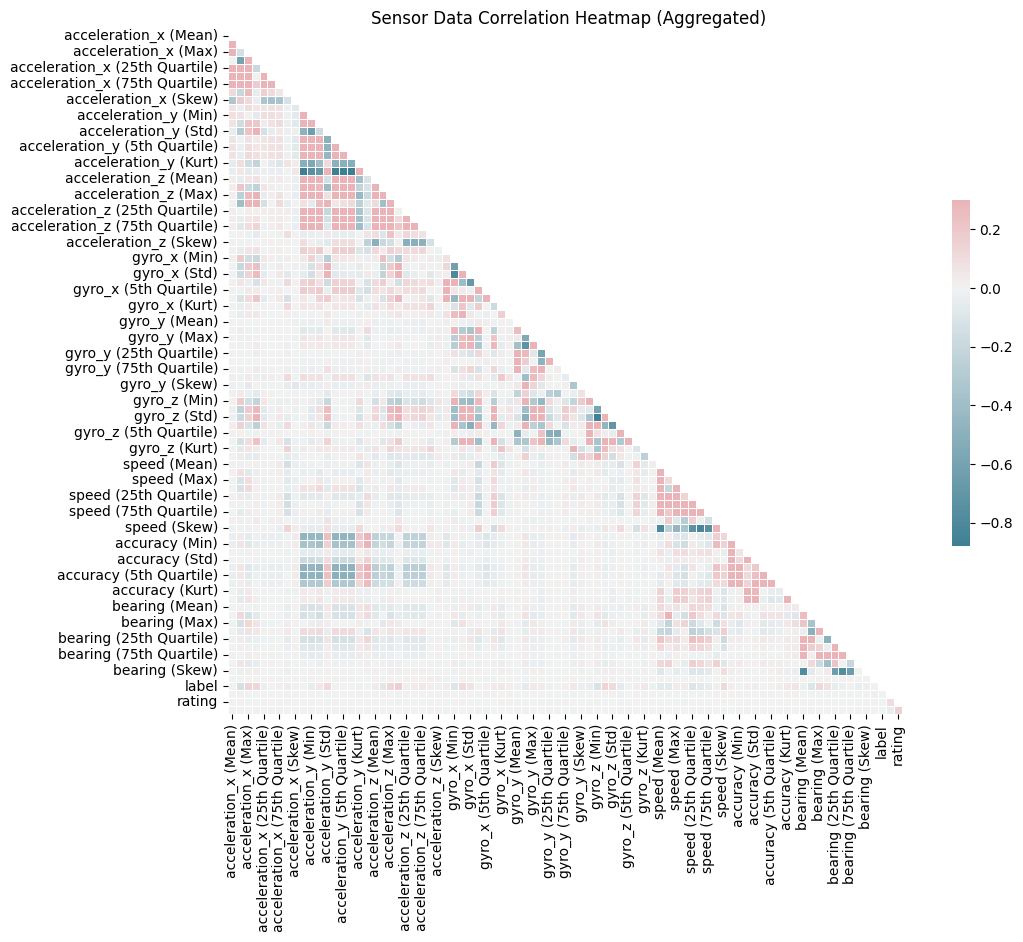

In [90]:
# Plot correlation matrix
plotCorrelation(filtered_df, 'Sensor Data Correlation Heatmap (Aggregated)', annot=False)

- Retrieve columns that have correlation greater than 0.6

In [91]:
def returnCorr(df=filtered_df, threshold = 0.6):
    # Correlation matrix
    corr_matrix = df.corr()

    # Retrieve values that are highly correlated
    threshold = threshold
    correlated_values = []
    for col in range(len(corr_matrix.columns)):
        for row in range(col+1, len(corr_matrix.index)):
            if abs(corr_matrix.iloc[row, col]) > threshold:
                correlated_values.append([corr_matrix.columns[col], corr_matrix.index[row], corr_matrix.iloc[row, col]])
    return correlated_values

- Remove columns that are highly correlated (greater than 0.6)

In [92]:
def removeCorr(filter_df=filtered_df, threshold=0.6):
    correlated_values = [0,1]
    while True:
        correlated_values = returnCorr(filter_df,threshold = threshold)
        high_correlated_df = pd.DataFrame(correlated_values, columns=['Column Name', 'Row Name', 'Correlation Coefficient'])
        high_correlated_df['Correlation Coefficient'] = high_correlated_df['Correlation Coefficient'].abs()
        comb = np.concatenate((high_correlated_df.iloc[:, 0], high_correlated_df.iloc[:, 1]), axis =0)
        unique, counts = np.unique(comb, return_counts=True)
        df = pd.DataFrame({'Value': unique, 'Count': counts})
        df.sort_values(by='Count', ascending=False, inplace=True)
        if len(df) != 0:
            filter_df = filter_df.drop(columns=[df.iloc[0][0]])
        else:
            break
    return filter_df

In [93]:
# Drop cols that are highly correlated
newSensor_df = removeCorr(filtered_df)

- Adding back car_model and gender columns

In [94]:
# Adding back gender and car_model
newSensor_df['gender'] = multivariate_outlier_sensor_agg['gender'].copy()
newSensor_df['car_model'] = multivariate_outlier_sensor_agg['car_model'].copy()

In [95]:
# Total no. of cols after removing correlated columns
print(f'Total No. of Columns: {len(newSensor_df.columns)}')

Total No. of Columns: 55


Train-Test-Split

In [96]:
# Defining X and y
X = newSensor_df.drop(['label'], axis=1)
y = newSensor_df['label']

In [97]:
# Train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [98]:
# Dimensions
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (13999, 54)
X_test shape: (6000, 54)


# 6. Feature Selection<a id='6'></a>

<br>

- [Back to content table](#content-table)

- Recursive Feature Elimination with Cross Validation

In [99]:
# Categorical columns will not be passed into RFECV
cat_columns = ['gender', 'car_model']

# Storing column names for display purposes later
X_train_num = X_train.drop(cat_columns, axis=1)
col_names = X_train_num.columns

In [101]:
# Folds
kfold = StratifiedKFold(n_splits=4, random_state=42, shuffle=True)

# RFECV pipeline with scaler
scaler = StandardScaler()
rf_classifier = RandomForestClassifier(random_state=42)
rfecv = RFECV(rf_classifier, cv=kfold, scoring='f1')
pipeline = Pipeline([('scaler', scaler), ('rfecv', rfecv)])

# Retrieve relevant columns
selector = pipeline.fit(X_train_num, y_train)

In [102]:
num_cols = selector.get_feature_names_out()
print(f'No. of Relevant Columns: {len(num_cols)}')

No. of Relevant Columns: 5


In [103]:
print(f'Relevant Columns: {num_cols}')

Relevant Columns: ['acceleration_z (Std)' 'speed (Std)' 'speed (Skew)' 'bearing (Std)'
 'second (Max)']


In [ ]:
# Accuracy achieved on validation set across each cv
print(f'f-1 score produced with relevent columns: {selector["rfecv"].cv_results_["mean_test_score"].max():.3f}')

In [104]:
# Accuracy achieved on validation set across each cv
print(f'Mean f-1 score: {selector["rfecv"].cv_results_["mean_test_score"].mean():.3f}')

Mean f-1 score: 0.301


- Using cross validation to evaluate model result

In [140]:
# Train model
def model_tester(name, pipeline, X_train, y_train):
    with mlflow.start_run():
        # Kfold
        kfold = StratifiedKFold(n_splits=4, random_state=100, shuffle=True)
        results = {}
        for metric in ['accuracy', 'recall', 'precision', 'f1', 'roc_auc']: 
            cv_results = cross_val_score(pipeline, X_train, y_train, cv=kfold, scoring=metric).mean()
            mlflow.log_metric(metric, cv_results)
            results[metric] = cv_results

        # Log results
        mlflow.sklearn.log_model(pipeline.named_steps['model'], name)
        print(f'{name} Trained')
    return results

Manually checking performance of model with the categorical columns (gender and car_model)

In [156]:
# MLFlow tracking
mlflow.set_tracking_uri("http://localhost:5000")

# Creating new experiment
experiment_name="Feature_Selection_Comparison"
mlflow.set_experiment(experiment_name)

2023/02/07 13:16:25 INFO mlflow.tracking.fluent: Experiment with name 'Outlier_Removal_Comparison' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/276849074381385188', creation_time=1675746985355, experiment_id='276849074381385188', last_update_time=1675746985355, lifecycle_stage='active', name='Outlier_Removal_Comparison', tags={}>

In [157]:
# Train without categorical columns (only relevant columns extracted earlier from RFECV)
X_train_num = X_train_num[num_cols]
scaler = StandardScaler()

name = 'Model (Numerical Columns Only)'
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_num = Pipeline([('scaler', scaler), ('model', rf_classifier)])
result_numerical = model_tester(name, pipeline_num, X_train_num, y_train)
result_numerical['Model'] = name

Model (Numerical Columns Only) Trained


In [158]:
# Train with gender column
X_train_gender = X_train[np.append(num_cols, 'gender')].copy()
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['gender'])]
)

name = 'Model (With Gender)'
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_gender = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])
result_gender = model_tester(name, pipeline_gender, X_train_gender, y_train)
result_gender['Model'] = name

Model (With Gender) Trained


In [159]:
# Train with car model column
X_train_car = X_train[np.append(num_cols, 'car_model')].copy()
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)

name = 'Model (With Car Model)'
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_car = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])
result_car_model = model_tester(name, pipeline_car, X_train_car, y_train)
result_car_model['Model'] = name

Model (With Car Model) Trained


In [160]:
# Train with car model and gender column
X_train_cat = X_train[np.append(num_cols, ['car_model', 'gender'])].copy()
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model', 'gender'])]
)

rf_classifier = RandomForestClassifier(random_state=42)
name = 'Model (With Car Model & Gender)'
pipeline_cat = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])
result_cat = model_tester(name, pipeline_cat, X_train_cat, y_train)
result_cat['Model'] = name 

Model (With Car Model & Gender) Trained


In [161]:
# Display results
result = pd.DataFrame([result_numerical, result_gender, result_car_model, result_cat])
display(result[['Model', 'accuracy', 'f1', 'recall', 'precision', 'roc_auc']])

,Model,accuracy,f1,recall,precision,roc_auc
0,Model (Numerical Columns Only),0.770126,0.329277,0.226100,0.606249,0.697010
1,Model (With Gender),0.772055,0.323433,0.218370,0.623996,0.700120
2,Model (With Car Model),0.772198,0.318414,0.213222,0.629606,0.702556
3,Model (With Car Model & Gender),0.771127,0.314504,0.210360,0.624362,0.702035


# 7. Outlier Removal Techniques Comparison<a id='7'></a>
We have 3 sets of data to compare
1. with all outliers 
2. without outliers (univariate detection)
3. without outliers (multivariate detection)

we will use number 3 to test which feature selection and imbalanced class handling methods are best

<br>

- [Back to content table](#content-table)

In [189]:
def split_data(data):
    # Defining X and y
    X = data.drop(['label'], axis=1)
    y = data['label']

    # Train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    return X_train, X_test, y_train, y_test

In [190]:
# Creating new experiment
experiment_name="Outlier_Removal_Comparison"
mlflow.set_experiment(experiment_name)

2023/02/07 14:23:03 INFO mlflow.tracking.fluent: Experiment with name 'Outlier_Removal_Comparison' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/334139857518420483', creation_time=1675750983340, experiment_id='334139857518420483', last_update_time=1675750983340, lifecycle_stage='active', name='Outlier_Removal_Comparison', tags={}>

### Original Data (With Outliers)

In [234]:
# Original data (with outliers)
og_sensor_agg = pd.read_csv('og_sensor_agg.csv')
og_sensor_agg = og_sensor_agg[['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)', 'car_model', 'label']]
X_train_origin, X_test_origin, y_train_origin, y_test_origin = split_data(og_sensor_agg)

In [193]:
# Original dataset
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
name = 'Model (With Outliers)'
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_origin = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])
result_origin = model_tester(name, pipeline_origin, X_train_origin, y_train_origin)
result_origin['Model'] = name 

Model (With Outliers) Trained


### Inliers from Univariate Outlier Removal

In [194]:
# Inliers (Univariate Outlier removal)
univariate_outlier_sensor_agg = pd.read_csv('univariate_outlier_sensor_agg.csv')
univariate_outlier_sensor_agg = univariate_outlier_sensor_agg[['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)', 'car_model', 'label']]
X_train_uni, X_test_uni, y_train_uni, y_test_uni = split_data(univariate_outlier_sensor_agg)

In [195]:
# Univariate outlier removal 
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
name = 'Model (Univariate Outlier Removal)'
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_uni = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])
result_uni = model_tester(name, pipeline_uni, X_train_uni, y_train_uni)
result_uni['Model'] = name 

Model (Univariate Outlier Removal) Trained


### Inliers from Multivariate Outlier Removal

In [196]:
# Inliers (Multivariate Outlier removal)
multivariate_outlier_sensor_agg = pd.read_csv('multivariate_outlier_sensor_agg.csv')
multivariate_outlier_sensor_agg = multivariate_outlier_sensor_agg[['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)', 'car_model', 'label']]
X_train_multi, X_test_multi, y_train_multi, y_test_multi = split_data(multivariate_outlier_sensor_agg)

In [197]:
# Inliers (Multivariate Outlier removal)
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
name = 'Model (Multivariate Outlier Removal)'
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_multi = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])
result_multi = model_tester(name, pipeline_multi, X_train_multi, y_train_multi)
result_multi['Model'] = name 

Model (Multivariate Outlier Removal) Trained


In [188]:
# Display results
result = pd.DataFrame([result_origin, result_uni, result_multi])
display(result[['Model', 'accuracy', 'f1', 'recall', 'precision', 'roc_auc']])

,Model,accuracy,f1,recall,precision,roc_auc
0,Model (With Outliers),0.774000,0.331982,0.225089,0.632901,0.704892
1,Model (Univariate Outlier Removal),0.771500,0.328926,0.224338,0.616468,0.703967
2,Model (Multivariate Outlier Removal),0.767485,0.311381,0.210563,0.598905,0.700348


**Note that the scores above are NOT comparable with one another because these are just CV results, they are NOT compared against the same data which is supposed to be the holdout original sensor data with outlier**. Hence see below for more objective comparison 😊

### Testing on original holdout set with outliers
- We tested against the dataset with outliers because this is based on the assumption that the sensor we are using is the same as the taxi driver's

A manual split function with shuffling will be made as the values of each dataset is different, thus, even setting random_state in the train_test_split may not result in the same split across the different datasets.

In [ ]:
# Shuffle indexes
idx = np.arange(20000)
np.random.shuffle(idx)
train_idx = idx[:16000]
test_idx = idx[16000:]

In [4]:
def manual_split(data):
    X = data.drop(['label'], axis=1)
    y = data['label']

    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]

    X_test = X.iloc[test_idx]
    y_test = y.iloc[test_idx]

    return X_train, X_test, y_train, y_test

In [5]:
# Original data (with outliers)
og_sensor_agg = pd.read_csv('og_sensor_agg.csv')
og_sensor_agg = og_sensor_agg[['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)', 'car_model', 'label']]
X_train_origin, X_test_origin, y_train_origin, y_test_origin = manual_split(og_sensor_agg)

# Inliers (Univariate Outlier removal)
univariate_outlier_sensor_agg = pd.read_csv('univariate_outlier_sensor_agg.csv')
univariate_outlier_sensor_agg = univariate_outlier_sensor_agg[['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)', 'car_model', 'label']]
X_train_uni, X_test_uni, y_train_uni, y_test_uni = manual_split(univariate_outlier_sensor_agg)

# Inliers (Multivariate Outlier removal)
multivariate_outlier_sensor_agg = pd.read_csv('multivariate_outlier_sensor_agg.csv')
multivariate_outlier_sensor_agg = multivariate_outlier_sensor_agg[['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)', 'car_model', 'label']]
X_train_multi, X_test_multi, y_train_multi, y_test_multi = manual_split(multivariate_outlier_sensor_agg)

In [8]:
from sklearn import metrics

def show_results(y_test, y_pred):
    fig, ax = plt.subplots(2, 1, figsize=(5, 5))
    # Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', linewidths=0.1, linecolor='gray', ax=ax[0])
    ax[0].set_title('Confusion Matrix')

    # Plot ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].plot(fpr, tpr)
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title(f'ROC Curve')
    plt.tight_layout()
    plt.show()

    # Metrics
    # Accuracy
    accuracy_score = metrics.accuracy_score(y_test, y_pred)
    print(f'\nAccuracy Score: {accuracy_score:.3f}')

    # Recall Score
    recall_score = metrics.recall_score(y_test, y_pred)
    print(f'\nRecall Score: {recall_score:.3f}')

    # Precision Score
    precision_score = metrics.precision_score(y_test, y_pred)
    print(f'\nPrecision Score: {precision_score:.3f}')

    # F1 Score
    f1_score = metrics.f1_score(y_test, y_pred)
    print(f'\nF1 Score: {f1_score:.3f}')

    # AUC Score
    print(f'\nAUC Score: {metrics.roc_auc_score(y_test, y_pred):.3f}')

In [272]:
# Original dataset
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
name = 'Model (With Outliers)'
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_origin = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])

# Train on original dataset (with outliers)
pipeline_origin.fit(X_train_origin, y_train_origin)
# Test on original test set with outliers
yhat_origin = pipeline_origin.predict(X_test_origin)

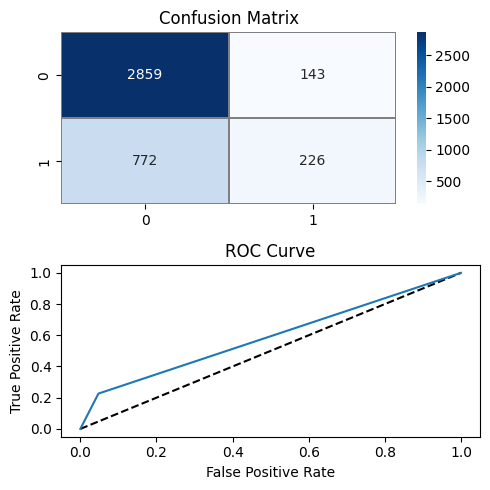


Accuracy Score: 0.771

Recall Score: 0.226

Precision Score: 0.612

F1 Score: 0.331

AUC Score: 0.589


In [273]:
show_results(y_test_origin, yhat_origin)

In [274]:
# Univariate outlier removal 
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_uni = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])

# Train on inliers from univariate outlier removal 
pipeline_uni.fit(X_train_uni, y_train_uni)
# Test on original test set with outliers
yhat_uni = pipeline_uni.predict(X_test_origin)

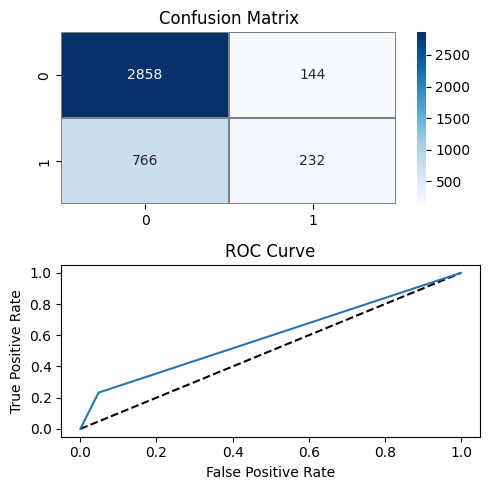


Accuracy Score: 0.772

Recall Score: 0.232

Precision Score: 0.617

F1 Score: 0.338

AUC Score: 0.592


In [275]:
show_results(y_test_origin, yhat_uni)

In [276]:
# Inliers (Multivariate Outlier removal)
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
rf_classifier = RandomForestClassifier(random_state=42)
pipeline_multi = Pipeline([('col_transform', col_transform), ('model', rf_classifier)])

# Train on inliers from Multivariate outlier removal 
pipeline_multi.fit(X_train_multi, y_train_multi)
# Test on original test set with outliers
yhat_multi = pipeline_multi.predict(X_test_origin)

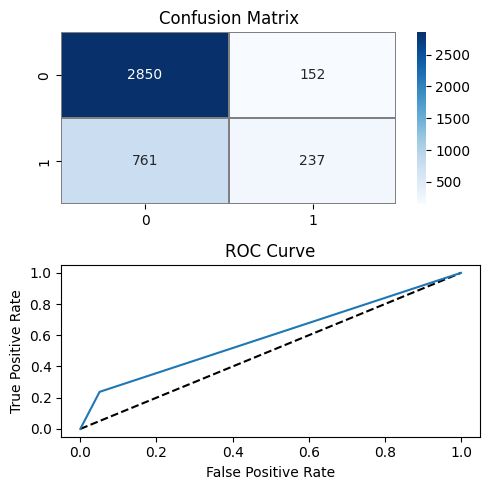


Accuracy Score: 0.772

Recall Score: 0.237

Precision Score: 0.609

F1 Score: 0.342

AUC Score: 0.593


In [277]:
show_results(y_test_origin, yhat_multi)

We tested the multivariate outlier removal training data with the original outlier testing data and seems like the multivariate removal data provided the best F1 score of (0.342) during testing.<br><br>

Note that all three original, univariate and multivariate are splitted with the same indices to keep data leakage to a minimum.

# 8. Handling Imbalanced Classes<a id='8'></a>
* Undersampling
* Random Oversampling
* SMOTE

<br>

- [Back to content table](#content-table)

In [281]:
# Creating new experiment
experiment_name="SamplingMethods_Comparison"
mlflow.set_experiment(experiment_name)

2023/02/07 15:29:53 INFO mlflow.tracking.fluent: Experiment with name 'SamplingMethods_Comparison' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/383827778368243504', creation_time=1675754993188, experiment_id='383827778368243504', last_update_time=1675754993188, lifecycle_stage='active', name='SamplingMethods_Comparison', tags={}>

### Base (no sampling)

In [282]:
# No sampling methods
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)

rf_classifier = RandomForestClassifier(random_state=42)
pipeline_base = Pipeline([
    ('col_transform', col_transform),
    ('model', rf_classifier)])

name = 'Model (No Sampling)'
result_base = model_tester(name, pipeline_base, X_train_multi, y_train_multi)
result_base['Model'] = name

Model (No Sampling) Trained


### Undersampling

In [283]:
from imblearn.pipeline import Pipeline as imb_Pipeline
from imblearn.under_sampling import ClusterCentroids

col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)

us_pipeline = imb_Pipeline(steps=[
    ('col_transform', col_transform),
    ('us', ClusterCentroids(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

name = 'Model (Under Sampling - Cluster Centroids)'
result_us = model_tester(name, us_pipeline, X_train_multi, y_train_multi)
result_us['Model'] = name

c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\quahj\anaco

Model (Under Sampling - Cluster Centroids) Trained


Ignore depreciation warnings...

### Oversampling SMOTE

In [285]:
from imblearn.over_sampling import SMOTE

col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)

smote_pipeline = imb_Pipeline(steps=[
    ('col_transform', col_transform),
    ('os', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

name = 'Model (SMOTE)'
result_smote = model_tester(name, smote_pipeline, X_train_multi, y_train_multi)
result_smote['Model'] = name

Model (SMOTE) Trained


### Oversampling Random

In [286]:
from imblearn.over_sampling import RandomOverSampler

col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)

random_os_pipeline = imb_Pipeline(steps=[
    ('col_transform', col_transform),
    ('os', RandomOverSampler(random_state=42)),
    ('model', RandomForestClassifier(random_state=42))
])

name = 'Model (Random Oversampling)'
result_random_os = model_tester(name, random_os_pipeline, X_train_multi, y_train_multi)
result_random_os['Model'] = name

Model (Random Oversampling) Trained


In [133]:
# Display results
result = pd.DataFrame([result_base, result_us, result_smote, result_random_os])
display(result[['Model', 'accuracy', 'f1', 'recall', 'precision', 'roc_auc']])

,Model,Accuracy,Recall,F1
0,Base,0.779786,0.189986,0.300914
1,UnderSampleCC,0.459286,0.827754,0.433260
2,OversampleSMOTE,0.727857,0.369099,0.403734
3,OversampleRandom,0.770714,0.236624,0.339896


# 9. Model Comparison<a id='9'></a>

<br>

- [Back to content table](#content-table)

In [288]:
# Creating new experiment
experiment_name="Model_Comparison"
mlflow.set_experiment(experiment_name)

2023/02/07 16:00:42 INFO mlflow.tracking.fluent: Experiment with name 'Model_Comparison' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/304381444826432551', creation_time=1675756842270, experiment_id='304381444826432551', last_update_time=1675756842270, lifecycle_stage='active', name='Model_Comparison', tags={}>

In [291]:
# Model Comparisons
random_state = 42
models = [
    ('LogisticRegression', LogisticRegression(random_state=random_state)),
    ('KNeighbors', KNeighborsClassifier()),
    ('DecisionTree', DecisionTreeClassifier(random_state=random_state)),
    ('RandomForest', RandomForestClassifier(random_state=random_state)),
    ('GradientBoosting', GradientBoostingClassifier(random_state=random_state)),
    ('BaggingClassifier', BaggingClassifier(random_state=random_state)),
    ('GaussianNaiveBayes', GaussianNB()),
    ('SupportVectorClassifier', SVC(random_state=random_state)),
    ('SGDClassifier', SGDClassifier(random_state=random_state)),
    ('AdaBoost', AdaBoostClassifier(random_state=random_state)),
    ('DummyClassifier (Frequent)', DummyClassifier(strategy='most_frequent',random_state=random_state)),
    ('DummyClassifier (Stratified)', DummyClassifier(strategy='stratified',random_state=random_state)),
    ('DummyClassifier (Uniform)', DummyClassifier(strategy='uniform',random_state=random_state))
]

results = [] # Store results

for name, model in models:
    # Classifier
    col_transform = ColumnTransformer(
        [('scale', StandardScaler(), num_cols),
        ('ohe', OneHotEncoder(), ['car_model'])]
    )
    model_pipeline = imb_Pipeline(steps=[
        ('col_transform', col_transform),
        ('os', SMOTE(random_state=42)),
        ('model', model)
    ])
    # Train classifier
    model_result = model_tester(name, model_pipeline, X_train_multi, y_train_multi)
    model_result['Model'] = name
    results.append(model_result)

LogisticRegression Trained
KNeighbors Trained
DecisionTree Trained
RandomForest Trained
GradientBoosting Trained
BaggingClassifier Trained
GaussianNaiveBayes Trained
SupportVectorClassifier Trained
SGDClassifier Trained
AdaBoost Trained


c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\quahj\anaconda3\envs\PAI\lib\site-packages\sklearn\metrics\_classification.py:1344

DummyClassifier (Frequent) Trained
DummyClassifier (Stratified) Trained
DummyClassifier (Uniform) Trained


In [295]:
# Results
result = pd.DataFrame(results).sort_values(by=['f1'], ascending=False)
display(result[['Model', 'accuracy', 'f1', 'recall', 'precision', 'roc_auc']])

,Model,accuracy,f1,recall,precision,roc_auc
4,GradientBoosting,0.638500,0.475494,0.656481,0.372765,0.716019
9,AdaBoost,0.646750,0.473760,0.636700,0.377425,0.713945
3,RandomForest,0.694375,0.438283,0.477715,0.405024,0.693331
8,SGDClassifier,0.533688,0.421569,0.680506,0.306641,0.620254
5,BaggingClassifier,0.681000,0.416666,0.456432,0.383333,0.665199
7,SupportVectorClassifier,0.554937,0.415785,0.634202,0.309346,0.615588
2,DecisionTree,0.627875,0.408200,0.514266,0.338496,0.589966
0,LogisticRegression,0.590688,0.407802,0.564847,0.319157,0.624297
6,GaussianNaiveBayes,0.249500,0.399119,0.998498,0.249406,0.602735
1,KNeighbors,0.574000,0.364724,0.490227,0.290430,0.567152


In [296]:
# Display results
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
model_pipeline = imb_Pipeline(steps=[
    ('col_transform', col_transform),
    ('os', SMOTE(random_state=42)),
    ('model',  GradientBoostingClassifier(random_state=42))
])

# Train on original dataset (with outliers)
model_pipeline.fit(X_train_multi, y_train_multi)

# Test on original test set with outliers
yhat_gbc = model_pipeline.predict(X_test_origin)

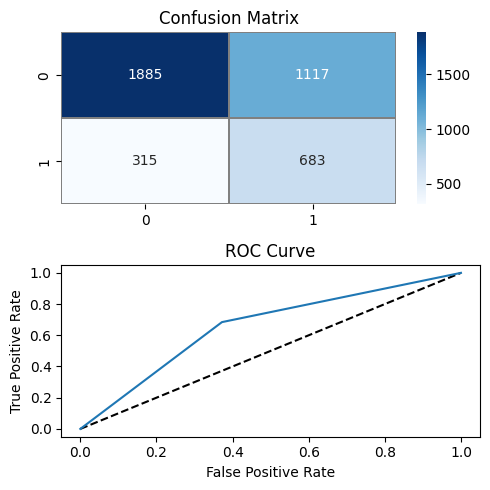


Accuracy Score: 0.642

Recall Score: 0.684

Precision Score: 0.379

F1 Score: 0.488

AUC Score: 0.656


In [297]:
show_results(y_test_origin, yhat_gbc)

# 10. Hyperparameter Tuning <a id='10'></a>
- Hyperband Search used

Hyperband is a popular algorithm for hyperparameter tuning in machine learning. It's a bandit-based method that balances exploration and exploitation to efficiently search the hyperparameter space. The balance of exploration and exploitation can be choosen in `Dask`'s aggressive parameter.

<br>

- [Back to content table](#content-table)

In [359]:
# from dask_ml.model_selection import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [361]:
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), num_cols),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
model_pipeline = imb_Pipeline(steps=[
    ('col_transform', col_transform),
    ('os', SMOTE(random_state=42)),
    ('model',  GradientBoostingClassifier(random_state=42))
])

param_grid = {
    # LR has a logscaled affect
    'model__learning_rate': np.logspace(3, 1, num=5) / 10000,
    'model__n_estimators': np.linspace(50,300,num=6).astype(int),
    'model__max_depth': np.arange(2,7),
    'model__subsample': np.linspace(0.8,1,num=4),
    'model__loss': ['log_loss', 'deviance', 'exponential']
}

hpt_xboosting = RandomizedSearchCV(model_pipeline,param_grid, scoring = 'f1', n_jobs=10, verbose=1, n_iter=100, cv=5)

hpt_xboosting.fit(X_train_multi, y_train_multi)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('col_transform',
                                              ColumnTransformer(transformers=[('scale',
                                                                               StandardScaler(),
                                                                               array(['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)',
       'bearing (Std)', 'second (Max)'], dtype=object)),
                                                                              ('ohe',
                                                                               OneHotEncoder(),
                                                                               ['car_model'])])),
                                             ('os', SMOTE(random_state=42)),
                                             ('model',
                                              GradientBoostingClassifier(random_state=42))]),
                   n_iter=100, n_jobs=10,
                   param_distributions={'model__learning_rate': array([0.1       , 0.03162278, 0.01      , 0.00316228, 0.001     ]),
                                        'model__loss': ['log_loss', 'deviance',
                                                        'exponential'],
                                        'model__max_depth': array([2, 3, 4, 5, 6]),
                                        'model__n_estimators': array([ 50, 100, 150, 200, 250, 300]),
                                        'model__subsample': array([0.8       , 0.86666667, 0.93333333, 1.        ])},
                   scoring='f1', verbose=1)

We did 100/1800 trials (about 6% of trials)

In [367]:
results.sort_values('rank_test_score')

,params,mean_test_score,rank_test_score
75,"{'model__subsample': 0.9333333333333333, 'mode...",0.483970,1
91,"{'model__subsample': 1.0, 'model__n_estimators...",0.482613,2
11,"{'model__subsample': 0.9333333333333333, 'mode...",0.482047,3
22,"{'model__subsample': 0.8666666666666667, 'mode...",0.481926,4
60,"{'model__subsample': 0.8666666666666667, 'mode...",0.481018,5
...,...,...,...
88,"{'model__subsample': 0.9333333333333333, 'mode...",0.456285,96
97,"{'model__subsample': 0.8666666666666667, 'mode...",0.455549,97
20,"{'model__subsample': 1.0, 'model__n_estimators...",0.455199,98
87,"{'model__subsample': 0.9333333333333333, 'mode...",0.454543,99


Lets log all the experiments during hyperparameter tuning (takes about 10 seconds only), sort by f1 score in MLFlow to easily observe the best hyperparameters too

In [385]:
# Creating new experiment
experiment_name="Hyperparameter_Tuning"
mlflow.set_experiment(experiment_name)

for index, row in results.iterrows():
    with mlflow.start_run():
        # Log F1 Score
        mlflow.log_metric('f1', row['mean_test_score'])
        # log ranking
        mlflow.log_metric('ranking', row['rank_test_score'])
        # Log hyperparameters
        for param, value in row['params'].items():
            mlflow.log_param(param, value)

2023/02/07 18:40:14 INFO mlflow.tracking.fluent: Experiment with name 'Hyperparameter_Tuning' does not exist. Creating a new experiment.


### Final test on best model (based on f1-score)

In [ ]:
xboosting_tuned = hpt_xboosting.best_estimator_

In [17]:
y_hat_final = xboosting_tuned.predict(X_test_origin)

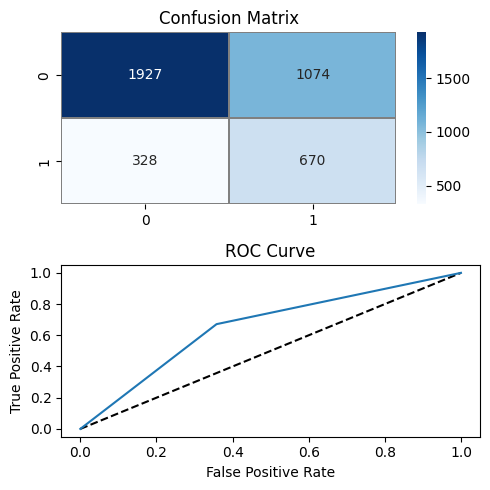


Accuracy Score: 0.649

Recall Score: 0.671

Precision Score: 0.384

F1 Score: 0.489

AUC Score: 0.657


In [18]:
show_results(y_test_origin, y_hat_final)

Now lets retrain the model with all the data and save it
- takes a few seconds
<br><br>


Best params:
- LR: 0.0316227
- Loss: exponential
- Max depth: 2
- n_estimators: 300
- subsample: 0.93333

In [31]:
col_transform = ColumnTransformer(
    [('scale', StandardScaler(), ['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)']),
    ('ohe', OneHotEncoder(), ['car_model'])]
)
model_pipeline = imb_Pipeline(steps=[
    ('col_transform', col_transform),
    ('os', SMOTE(random_state=42)),
    ('model',  GradientBoostingClassifier(random_state=42))
])

xboosting_tuned = model_pipeline.fit(multivariate_outlier_sensor_agg.drop(columns=['label']),multivariate_outlier_sensor_agg['label'])

In [34]:
import pickle

filename = 'XBoostingTuned.pkl'
with open(filename, 'wb') as file:
    pickle.dump(xboosting_tuned, file)

# 11. Training unsupervised models <a id='11'></a>
- Useful for analysis part of our app
- kPrototype + PCA

<br>

- [Back to content table](#content-table)

In [2]:
from kmodes.kprototypes import KPrototypes
from sklearn.neighbors import DistanceMetric
from sklearn.metrics import silhouette_score, silhouette_samples, euclidean_distances, davies_bouldin_score, calinski_harabasz_score

In [11]:
num_cols = ['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)']

In [20]:
multivariate_outlier_sensor_agg

,acceleration_z (Std),speed (Std),speed (Skew),bearing (Std),second (Max),car_model,label
0,1.096421,7.010870,0.151116,128.977014,1589.0,Mercedes-Benz,0
1,2.818097,1.916799,0.550355,118.891451,809.0,Mercedes-Benz,1
2,1.186513,9.029713,-0.683999,70.580133,1407.0,Mercedes-Benz,0
3,0.990569,7.964312,0.802410,91.795896,869.0,Mercedes-Benz,0
4,1.018549,4.972506,0.365089,33.265059,128.0,Mercedes-Benz,0
...,...,...,...,...,...,...,...
19994,1.331511,7.456193,-0.153840,90.030578,1439.0,Honda,0
19995,1.227215,5.326666,0.416506,129.313882,853.0,Honda,0
19996,1.021091,6.533076,0.529696,95.485810,1709.0,Honda,1
19997,1.102779,7.854344,-1.029153,83.628294,538.0,Honda,0


In [38]:
scaler = StandardScaler().fit(multivariate_outlier_sensor_agg[num_cols])

# Save scaler
filename = 'scaler.pkl'
with open(filename, 'wb') as file:
    pickle.dump(scaler, file)

In [45]:
multi_scaled = scaler.transform(multivariate_outlier_sensor_agg[num_cols])

multi_scaled = pd.DataFrame(multi_scaled, columns=num_cols)

multi_scaled = pd.concat([multi_scaled,multivariate_outlier_sensor_agg[['car_model','label']]], axis = 1)

In [49]:
cat_position = [5,6]


def run_kprototype(start=2,end=9,data=multi_scaled,category_position=cat_position):
    cost = []
    for cluster in range(start, end):
        try:
            kPro = KPrototypes(n_jobs = -1, n_clusters = cluster, random_state = 123,max_iter=500)
            cluster_label02 =  kPro.fit_predict(data, categorical = category_position)
            cost.append([cluster,kPro.cost_])
        except:
            pass
    return cost

In [50]:
costs = run_kprototype()

In [51]:
costs

[[2, 92891.67590798748],
 [3, 80886.28053866465],
 [4, 72105.44395133924],
 [5, 67571.87502402253],
 [6, 47615.07958689554],
 [7, 43918.52690971426],
 [8, 41877.908765218286]]

In [76]:
# Creating new experiment
mlflow.set_tracking_uri("http://localhost:5000")
experiment_name="Clusters_Comparison"
mlflow.set_experiment(experiment_name)

for cluster, cost in costs:
    with mlflow.start_run():
        # Log no. of clusters
        mlflow.log_param('n_cluster', cluster)
        # log cost
        mlflow.log_metric('cost', cost)

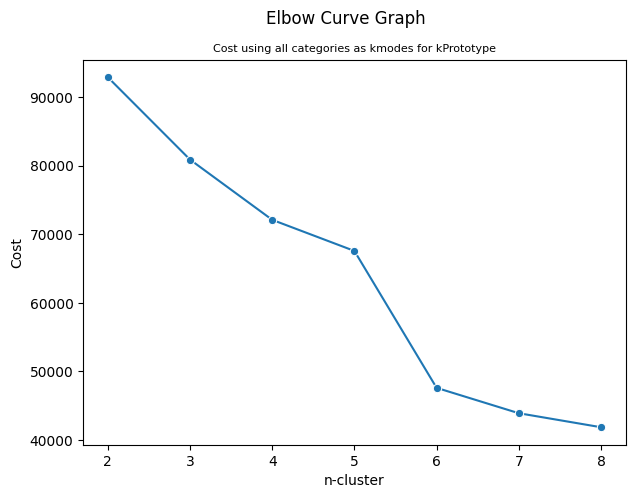

In [52]:
result_df = pd.DataFrame(
    costs, columns = [
        'n-cluster', 'Cost'
        ]
    )

fig, ax1  = plt.subplots(figsize=(7,5))

fig.suptitle('Elbow Curve Graph')
sns.lineplot(x='n-cluster', y='Cost', data = result_df, marker= 'o', ax=ax1)
ax1.set_title('Cost using all categories as kmodes for kPrototype', fontsize=8)
plt.show()

Looks like there should be 6 clusters

In [53]:
kPro = KPrototypes(n_jobs = 8, n_clusters = 6, random_state = 123,max_iter=500)
cluster_labels = kPro.fit_predict(multi_scaled, categorical=[5,6])

In [93]:
multi_scaled_cluster = pd.concat([multi_scaled,pd.DataFrame(cluster_labels,columns=['Cluster'])],axis=1)
multi_scaled_cluster

,acceleration_z (Std),speed (Std),speed (Skew),bearing (Std),second (Max),car_model,label,Cluster
0,0.027987,0.428256,-0.191503,1.388323,-0.012160,Mercedes-Benz,0,3
1,3.253814,-2.334746,0.343246,1.025095,-0.012263,Mercedes-Benz,1,4
2,0.196788,1.523268,-1.310074,-0.714816,-0.012184,Mercedes-Benz,0,0
3,-0.170343,0.945398,0.680853,0.049261,-0.012255,Mercedes-Benz,0,1
4,-0.117919,-0.677344,0.095097,-2.058702,-0.012352,Mercedes-Benz,0,2
...,...,...,...,...,...,...,...,...
19994,0.468465,0.669797,-0.599968,-0.014316,-0.012180,Honda,0,1
19995,0.273050,-0.485249,0.163966,1.400455,-0.012257,Honda,0,3
19996,-0.113156,0.169102,0.315575,0.182151,-0.012144,Honda,1,3
19997,0.039900,0.885752,-1.772380,-0.244892,-0.012298,Honda,0,0


In [76]:
cats = ['car_model', 'label']

#callback function for the function below
def cluster_category_analysis(cluster,nominal,clustered_data):
    cluster_size = clustered_data[clustered_data['Cluster']==cluster]['Cluster'].count()
    cluster_info_df = pd.DataFrame(columns=['Cluster','Attribute Name','Attribute Cluster Make up (%)'])
    cluster_lst = []
    for nominal_attr in clustered_data[nominal].unique():
        attr_cluster_count = clustered_data[(clustered_data['Cluster']==cluster) & (clustered_data[nominal]==nominal_attr)]['Cluster'].count()
        perc = (attr_cluster_count/cluster_size)*100
        attr_perc_df = pd.DataFrame([[cluster,f'{nominal}:{nominal_attr}',perc]],columns=['Cluster','Attribute Name','Attribute Cluster Make up (%)'])
        cluster_info_df = pd.concat([cluster_info_df,attr_perc_df])
        cluster_lst.append(cluster)
    cluster_info_df.index = cluster_lst
    return cluster_info_df

def cluster_analysis(cluster,clustered_data,nominal_cats):
    nominal_info = pd.DataFrame(columns=['Cluster','Attribute Name','Attribute Cluster Make up (%)'])
    for nominal in nominal_cats:
        nominal_info = pd.concat([nominal_info,cluster_category_analysis(cluster,nominal,clustered_data)])
    cluster_mask = clustered_data['Cluster']==cluster
    cluster_means = pd.DataFrame([clustered_data[cluster_mask].drop(columns=nominal_cats).mean()]).drop(columns=['Cluster'])
    cluster_df = pd.DataFrame([cluster],columns=['Cluster'])
    cluster_means = pd.concat([cluster_df,cluster_means],axis=1)
    cluster_means.index = [cluster]
    return cluster_means, nominal_info

### Centriod Information

Scaled Centriods

In [61]:
num_cols.append('car_model')
num_cols.append('label')

centroids = pd.DataFrame(kPro.cluster_centroids_,columns=num_cols)
centroids

,acceleration_z (Std),speed (Std),speed (Skew),bearing (Std),second (Max),car_model,label
0,-0.1420351538585575,0.2259404761103533,-1.1319263896359906,-1.268081694493574,-0.012251758689738712,Toyota,0
1,-0.04084730860184828,1.0423688613899547,-0.37697712845674686,0.29453104216849013,-0.012216728925631649,Toyota,0
2,-0.17854909282421863,-0.6492570713940703,0.5730041172729022,-0.649275531068672,-0.01226719419794361,Toyota,0
3,-0.13386251893498663,-0.5589762190495824,0.39450139121640104,0.9067844486488882,-0.012267789475065285,Toyota,0
4,4.9663662590644755,-1.1223562361375723,1.2155575239134022,0.15064292066218088,-0.012208971065783312,Toyota,1
5,0.02471568298596009,0.36063331469508025,0.4457990287083271,0.5451095850724059,81.64149255459975,Chevrolet,0


Unscaled Centriods (inverse transform)

In [75]:
pd.concat([pd.DataFrame(scaler.inverse_transform(centroids[['acceleration_z (Std)','speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)']]),columns=['acceleration_z (Std)','speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)']),centroids[['car_model','label']]], axis=1)

,acceleration_z (Std),speed (Std),speed (Skew),bearing (Std),second (Max),car_model,label
0,1.005678,6.637867,-0.550996,55.217848,8.918545e+02,Toyota,0
1,1.059683,8.143094,0.012643,98.606202,1.157543e+03,Toyota,0
2,0.986189,5.024289,0.721891,72.399956,7.747815e+02,Toyota,0
3,1.010039,5.190737,0.588622,115.606363,7.702666e+02,Toyota,0
4,3.732114,4.152049,1.201616,94.610926,1.216384e+03,Toyota,1
5,1.094675,6.886196,0.626921,105.563902,6.193160e+08,Chevrolet,0


In [94]:
cluster_cat_info = pd.DataFrame(columns=['Attribute Name','Attribute Cluster Make up (%)'])
cluster_means_info = pd.DataFrame(columns=multi_scaled_cluster.drop(columns=cats).columns)
for i in range(6):
    clustered_results = cluster_analysis(i,multi_scaled_cluster, cats)
    print(f'\nCluster: {i}')
    display(clustered_results)
    cluster_cat_info = pd.concat([clustered_results[1],cluster_cat_info])
    cluster_means_info = pd.concat([clustered_results[0],cluster_means_info])


Cluster: 0


(   Cluster  acceleration_z (Std)  speed (Std)  speed (Skew)  bearing (Std)  \
 0        0             -0.142035      0.22594     -1.131926      -1.268082   
 
    second (Max)  
 0     -0.012252  ,
   Cluster           Attribute Name  Attribute Cluster Make up (%)
 0       0  car_model:Mercedes-Benz                       5.164319
 0       0        car_model:Hyundai                      10.026828
 0       0         car_model:Toyota                      20.456070
 0       0     car_model:Volkswagen                      12.709591
 0       0            car_model:BMW                       2.213280
 0       0          car_model:Mazda                      11.032864
 0       0         car_model:Nissan                      12.072435
 0       0          car_model:Honda                       7.176392
 0       0      car_model:Chevrolet                       8.819584
 0       0           car_model:Ford                      10.328638
 0       0                  label:0                      86.1502


Cluster: 1


(   Cluster  acceleration_z (Std)  speed (Std)  speed (Skew)  bearing (Std)  \
 1        1             -0.040847     1.042369     -0.376977       0.294531   
 
    second (Max)  
 1     -0.012217  ,
   Cluster           Attribute Name  Attribute Cluster Make up (%)
 1       1  car_model:Mercedes-Benz                       5.337362
 1       1        car_model:Hyundai                      10.976838
 1       1         car_model:Toyota                      20.359181
 1       1     car_model:Volkswagen                      13.175562
 1       1            car_model:BMW                       2.047667
 1       1          car_model:Mazda                      11.077543
 1       1         car_model:Nissan                      12.269218
 1       1          car_model:Honda                       7.351460
 1       1      car_model:Chevrolet                       7.334676
 1       1           car_model:Ford                      10.070493
 1       1                  label:0                      70.5102


Cluster: 2


(   Cluster  acceleration_z (Std)  speed (Std)  speed (Skew)  bearing (Std)  \
 2        2             -0.178549    -0.649257      0.573004      -0.649276   
 
    second (Max)  
 2     -0.012267  ,
   Cluster           Attribute Name  Attribute Cluster Make up (%)
 2       2  car_model:Mercedes-Benz                       5.634662
 2       2        car_model:Hyundai                      10.598047
 2       2         car_model:Toyota                      20.606184
 2       2     car_model:Volkswagen                      13.201790
 2       2            car_model:BMW                       1.830757
 2       2          car_model:Mazda                      10.496338
 2       2         car_model:Nissan                      12.144020
 2       2          car_model:Honda                       7.689178
 2       2      car_model:Chevrolet                       7.282343
 2       2           car_model:Ford                      10.516680
 2       2                  label:0                      76.7697


Cluster: 3


(   Cluster  acceleration_z (Std)  speed (Std)  speed (Skew)  bearing (Std)  \
 3        3             -0.133863    -0.558976      0.394501       0.906784   
 
    second (Max)  
 3     -0.012268  ,
   Cluster           Attribute Name  Attribute Cluster Make up (%)
 3       3  car_model:Mercedes-Benz                       5.813953
 3       3        car_model:Hyundai                      11.504581
 3       3         car_model:Toyota                      19.855532
 3       3     car_model:Volkswagen                      13.002114
 3       3            car_model:BMW                       1.955603
 3       3          car_model:Mazda                      10.324172
 3       3         car_model:Nissan                      12.455955
 3       3          car_model:Honda                       7.381959
 3       3      car_model:Chevrolet                       7.540521
 3       3           car_model:Ford                      10.165610
 3       3                  label:0                      76.3918


Cluster: 4


(   Cluster  acceleration_z (Std)  speed (Std)  speed (Skew)  bearing (Std)  \
 4        4              4.966366    -1.122356      1.215558       0.150643   
 
    second (Max)  
 4     -0.012209  ,
   Cluster           Attribute Name  Attribute Cluster Make up (%)
 4       4  car_model:Mercedes-Benz                       4.310345
 4       4        car_model:Hyundai                      12.931034
 4       4         car_model:Toyota                      18.534483
 4       4     car_model:Volkswagen                      15.948276
 4       4            car_model:BMW                       1.939655
 4       4          car_model:Mazda                      11.637931
 4       4         car_model:Nissan                      12.715517
 4       4          car_model:Honda                       6.034483
 4       4      car_model:Chevrolet                       6.681034
 4       4           car_model:Ford                       9.267241
 4       4                  label:0                      26.7241


Cluster: 5


(   Cluster  acceleration_z (Std)  speed (Std)  speed (Skew)  bearing (Std)  \
 5        5              0.024716     0.360633      0.445799        0.54511   
 
    second (Max)  
 5     81.641493  ,
   Cluster           Attribute Name  Attribute Cluster Make up (%)
 5       5  car_model:Mercedes-Benz                      33.333333
 5       5        car_model:Hyundai                      33.333333
 5       5         car_model:Toyota                       0.000000
 5       5     car_model:Volkswagen                       0.000000
 5       5            car_model:BMW                       0.000000
 5       5          car_model:Mazda                       0.000000
 5       5         car_model:Nissan                       0.000000
 5       5          car_model:Honda                       0.000000
 5       5      car_model:Chevrolet                      33.333333
 5       5           car_model:Ford                       0.000000
 5       5                  label:0                     100.0000

In [95]:
for i in range(6):
    print(f"Cluster {i} count: {len(multi_scaled_cluster[multi_scaled_cluster['Cluster']==i])}")

Cluster 0 count: 2982
Cluster 1 count: 5958
Cluster 2 count: 4916
Cluster 3 count: 5676
Cluster 4 count: 464
Cluster 5 count: 3


Note that the normal observed distribution for safe and dangerous trips is 25% to 75%:<br>
So from the information above we can start interperting the clusters:
- Cluster 1 & 4 has higher than 25% dangerous drivers (observed average dangerous trip). <br><br>
Cluster 4 contains 73% dangerous drivers, which is way higher than the observed average dangerous trip of 25%, which means cluster 4 can mean that it contains dangerous drivers. Therefore, we should warn drivers to that are frequently getting trips labelled as 4. Seems like the main cause for its high percentage of dangerous label could be attributed to accelerating (std), bearing (std) & speed (skewness), which makes sense, people should not like violent trips...where you speed up very quickly (acceleration) or turn a lot (bearing)<br><br>
Cluster 1 contains 30% dangerous drivers, which could mean these are drivers on the verge of being labelled as dangerous. Cluster 1 also have its centriod distant closest to Cluster 4's centriod. If the trip is labelled as Cluster 1, we can warn the driver to drive more safely before being flagged as a dangerous driver in the future.

- Cluster 0 has the highest safety label at 84% and looking at the attributes it can tell us the characteristics of safe drivers. Seems like safer drivers have lower acceleration standard deviation and speed skewness, which means these drivers are more careful. Drivers frequently labelled as cluster 6 can be given a praise to let them know they are doing good.

- Cluster 5 are clearly outliers, and looking at the values, these are trips where the drivers that clearly driving dangerously especially with the high acceleration (std), speed (skewness) & bearing (std) but these trips are still labelled as safe. This could happen when the client is perhaps nice or in a hurry. Drivers that are labeled as Cluster 5 will also get the same warning as Cluster 1, where we will warn the driver to drive more safely otherwise they will be labelled as dangerous drivers. Another analysis would be since there is only 3/20000 datapoints in this cluster it could also mean the sensor of drivers in Cluster 5 are faulty.

- Cluster 2 & 3 are characteristics of the average driver. They will not get a warning.

In [100]:
num_cols.pop()
num_cols.pop()

'car_model'

In [115]:
principal_components

array([[-0.02304285,  1.32594631],
       [ 2.84561168,  0.33602516],
       [-1.97122707,  0.08830167],
       ...,
       [ 0.13058933,  0.20231733],
       [-1.82090733,  0.17480115],
       [ 2.24338056, -0.37964689]])

In [114]:
multi_scaled_cluster

,acceleration_z (Std),speed (Std),speed (Skew),bearing (Std),second (Max),car_model,label,Cluster
0,0.027987,0.428256,-0.191503,1.388323,-0.012160,Mercedes-Benz,0,3
1,3.253814,-2.334746,0.343246,1.025095,-0.012263,Mercedes-Benz,1,4
2,0.196788,1.523268,-1.310074,-0.714816,-0.012184,Mercedes-Benz,0,0
3,-0.170343,0.945398,0.680853,0.049261,-0.012255,Mercedes-Benz,0,1
4,-0.117919,-0.677344,0.095097,-2.058702,-0.012352,Mercedes-Benz,0,2
...,...,...,...,...,...,...,...,...
19994,0.468465,0.669797,-0.599968,-0.014316,-0.012180,Honda,0,1
19995,0.273050,-0.485249,0.163966,1.400455,-0.012257,Honda,0,3
19996,-0.113156,0.169102,0.315575,0.182151,-0.012144,Honda,1,3
19997,0.039900,0.885752,-1.772380,-0.244892,-0.012298,Honda,0,0


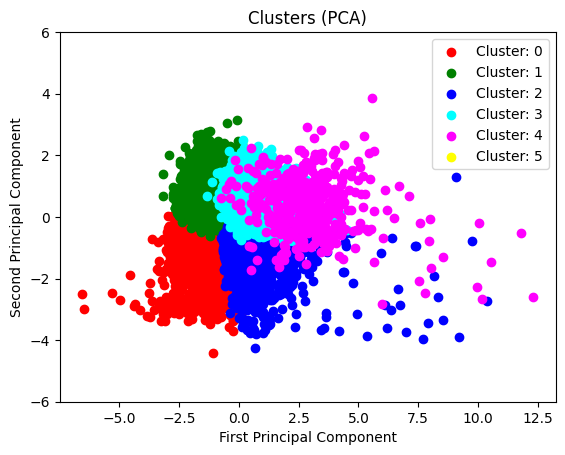

In [109]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principal_components = pca.fit_transform(multi_scaled_cluster[num_cols])

clusters = [0, 1, 2, 3, 4, 5]
colors = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow']
for cluster, color in zip(clusters, colors):
    plt.scatter(principal_components[multi_scaled_cluster['Cluster'] == cluster, 0], 
                principal_components[multi_scaled_cluster['Cluster'] == cluster, 1], 
                c=color, label=f"Cluster: {cluster}")
    
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.ylim(-6,6)
plt.title('Clusters (PCA)')
plt.legend()
plt.show()

In [10]:
pd.DataFrame(pca.components_, columns=['acceleration_z (Std)', 'speed (Std)', 'speed (Skew)', 'bearing (Std)', 'second (Max)'])

,acceleration_z (Std),speed (Std),speed (Skew),bearing (Std),second (Max)
0,0.279491,-0.61261,0.691250,0.262149,0.006785
1,0.153612,0.43018,0.003788,0.822762,0.338228


- PC1: We can see that positive acceleration and bearing standard deviation, while negative speed (std) will give a higher PC1
- PC2: We can see that positive acceleration, speed (skew), bearing and second (Max)

In [110]:
# Save unsupervised models
filename = 'unsupervised_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(kPro, file)

filename = 'pca.pkl'
with open(filename, 'wb') as file:
    pickle.dump(pca, file)

To conclude we trained 1 main supervised learning model to predict the safe and dangerous labels of trips, and also trained 2 unsupervised learning model for analysis for our application.